# Significance Testing

This demo shows how to handle significance testing from a functional perspective of ``climpred``. In the future, we will have a robust significance testing framework inplemented with ``HindcastEnsemble`` and ``PerfectModelEnsemble`` objects.

In [1]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [2]:
import xarray as xr
from climpred.tutorial import load_dataset
from climpred import HindcastEnsemble, PerfectModelEnsemble
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

In [3]:
# load data
v = "SST"
hind = load_dataset("CESM-DP-SST")[v]
hind.lead.attrs["units"] = "years"

hist = load_dataset("CESM-LE")[v]
hist = hist - hist.mean()

obs = load_dataset("ERSST")[v]
obs = obs - obs.mean()

<IPython.core.display.Javascript object>

/Users/aaron.spring/Coding/climpred/climpred/utils.py:122: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  warnings.warn(


<AxesSubplot:xlabel='time', ylabel='SST'>

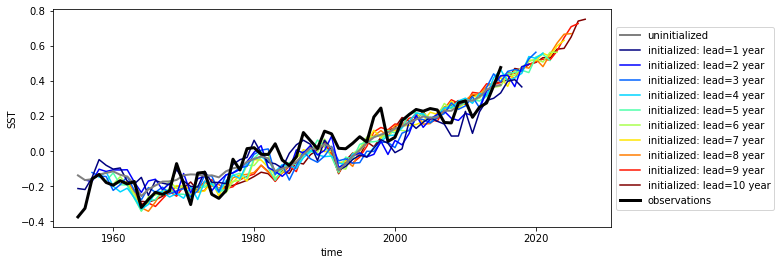

<IPython.core.display.Javascript object>

In [4]:
hindcast = HindcastEnsemble(hind)
hindcast = hindcast.add_uninitialized(hist)
hindcast = hindcast.add_observations(obs)

hindcast.plot()

Here we see the strong trend due to climate change. This trend is not linear but rather quadratic. Because we often aim to prediction natural variations and not specifically the external forcing in initialized predictions, we remove the 2nd-order trend from each dataset along a time axis.

<AxesSubplot:xlabel='time', ylabel='SST'>

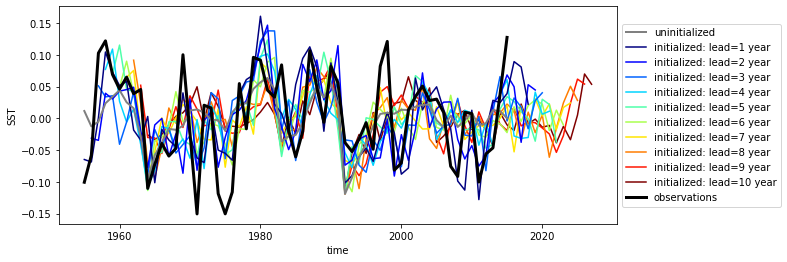

<IPython.core.display.Javascript object>

In [5]:
from climpred.stats import rm_poly

hindcast = hindcast.map(rm_poly, dim="init_or_time", deg=2)

hindcast.plot()

## p value for temporal correlations
For correlation metrics the associated p-value checks whether the correlation 
is significantly different from zero incorporating reduced degrees of freedom 
due to temporal autocorrelation.

In [6]:
# level that initialized ensembles are significantly better than other forecast skills
sig = 0.05

<IPython.core.display.Javascript object>

In [7]:
acc = hindcast.verify(
    metric="pearson_r", comparison="e2o", dim="init", alignment="same_verif"
)["SST"]
acc_p_value = hindcast.verify(
    metric="pearson_r_eff_p_value", comparison="e2o", dim="init", alignment="same_verif"
)["SST"]

<IPython.core.display.Javascript object>

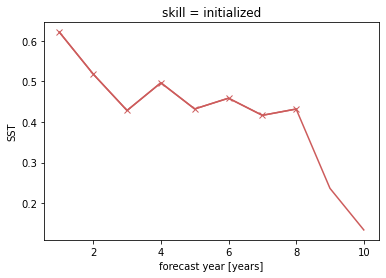

<IPython.core.display.Javascript object>

In [8]:
init_color = "indianred"
acc.plot(c=init_color)
acc.where(acc_p_value <= sig).plot(marker="x", c=init_color)

## Bootstrapping with replacement

Bootstrapping significance relies on resampling the underlying data with replacement for a large number of iterations as proposed by the decadal prediction framework of Goddard et al. 2013. We just use 20 iterations here to demonstrate the functionality.

In [9]:
%%time
bootstrapped_acc = hindcast.bootstrap(metric="pearson_r", comparison="e2r", dim='init', alignment='same_verif',
                                      iterations=500, sig=95, reference=['uninitialized', 'persistence', 'climatology'])

CPU times: user 1.25 s, sys: 188 ms, total: 1.44 s
Wall time: 1.62 s


<IPython.core.display.Javascript object>

In [10]:
bootstrapped_acc.coords

Coordinates:
  * lead     (lead) int32 1 2 3 4 5 6 7 8 9 10
  * results  (results) <U12 'verify skill' 'p' 'low_ci' 'high_ci'
  * skill    (skill) <U13 'initialized' 'uninitialized' ... 'climatology'

<IPython.core.display.Javascript object>

`bootstrap_acc` contains skill of `initialized` and reference given by `reference`:
- `initialized` for the initialized hindcast `hind` and describes skill due to initialization and external forcing
- `uninitialized` for the uninitialized historical `hist` and approximates skill from external forcing
- `persistence` for the reference persistence forecast

for different results:
- `verify skill`: skill values
- `p`: p value that reference forecast is better than initialized
- `low_ci` and `high_ci`: high and low ends of confidence intervals based on significance threshold `sig`

In [11]:
init_skill = bootstrapped_acc[v].sel(results="verify skill", skill="initialized")
init_better_than_uninit = init_skill.where(
    bootstrapped_acc[v].sel(results="p", skill="uninitialized") <= sig
)
init_better_than_persistence = init_skill.where(
    bootstrapped_acc[v].sel(results="p", skill="persistence") <= sig
)

<IPython.core.display.Javascript object>

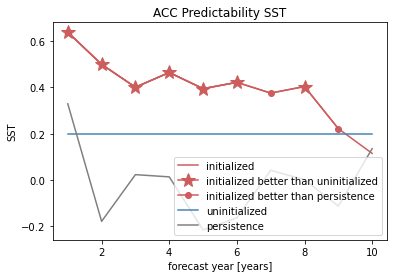

<IPython.core.display.Javascript object>

In [12]:
# create a plot by hand
bootstrapped_acc[v].sel(results="verify skill", skill="initialized").plot(
    c=init_color, label="initialized"
)
init_better_than_uninit.plot(
    c=init_color,
    marker="*",
    markersize=15,
    label="initialized better than uninitialized",
)
init_better_than_persistence.plot(
    c=init_color, marker="o", label="initialized better than persistence"
)
bootstrapped_acc[v].sel(results="verify skill", skill="uninitialized").plot(
    c="steelblue", label="uninitialized"
)
bootstrapped_acc[v].sel(results="verify skill", skill="persistence").plot(
    c="gray", label="persistence"
)
plt.title(f"ACC Predictability {v}")
plt.legend(loc="lower right")

<AxesSubplot:xlabel='Lead time [years]', ylabel='Pearson product-moment correlation coefficient'>

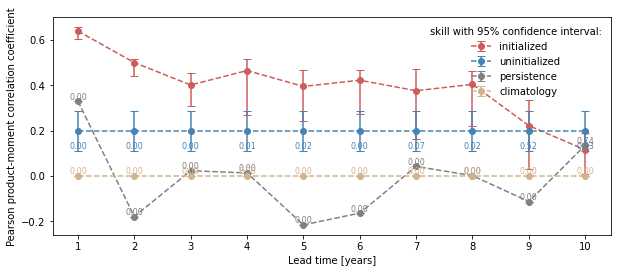

<IPython.core.display.Javascript object>

In [13]:
# use climpred convenience plotting function
from climpred.graphics import plot_bootstrapped_skill_over_leadyear

plot_bootstrapped_skill_over_leadyear(bootstrapped_acc)

## Field significance

Using `esmtools.testing.multipletests` to control the false discovery
rate (FDR) from the above obtained p-values in geospatial data.

In [14]:
v = "tos"
ds3d = load_dataset("MPI-PM-DP-3D")[v]
ds3d.lead.attrs["unit"] = "years"
control3d = load_dataset("MPI-control-3D")[v]

<IPython.core.display.Javascript object>

In [15]:
pm = PerfectModelEnsemble(ds3d)
pm = pm.add_control(control3d)

/Users/aaron.spring/Coding/climpred/climpred/utils.py:122: UserWarning: Assuming annual resolution due to numeric inits. Change init to a datetime if it is another resolution.
  warnings.warn(


<IPython.core.display.Javascript object>

### p value for temporal correlations

Lets first calculate the Pearson's Correlation p-value and then correct afterwards by FDR.

In [16]:
acc3d = pm.verify(metric="pearson_r", comparison="m2e", dim=["init", "member"])[v]
acc_p_3d = pm.verify(
    metric="pearson_r_p_value", comparison="m2e", dim=["init", "member"]
)[v]

<IPython.core.display.Javascript object>

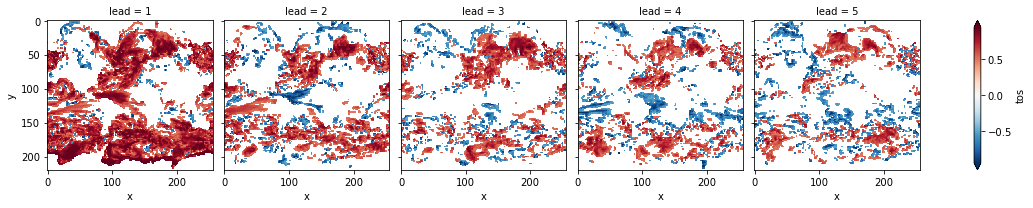

<IPython.core.display.Javascript object>

In [17]:
# mask init skill where not significant
acc3d.where(acc_p_3d <= sig).plot(col="lead", robust=True, yincrease=False, x="x")

In [18]:
# apply FDR Benjamini-Hochberg
# relies on esmtools https://github.com/bradyrx/esmtools
from esmtools.testing import multipletests

_, acc_p_3d_fdr_corr = multipletests(acc_p_3d, method="fdr_bh", alpha=sig)

<IPython.core.display.Javascript object>

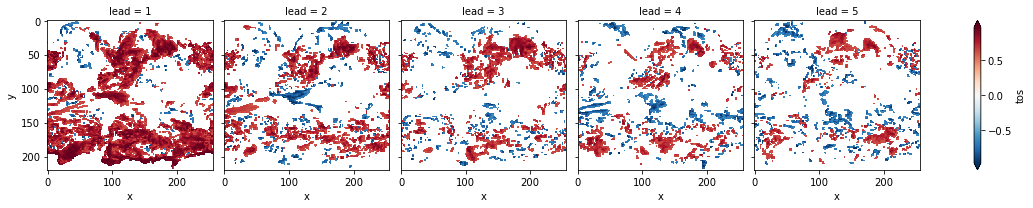

<IPython.core.display.Javascript object>

In [19]:
# mask init skill where not significant on corrected p-values
acc3d.where(acc_p_3d_fdr_corr <= sig).plot(
    col="lead", robust=True, yincrease=False, x="x"
)

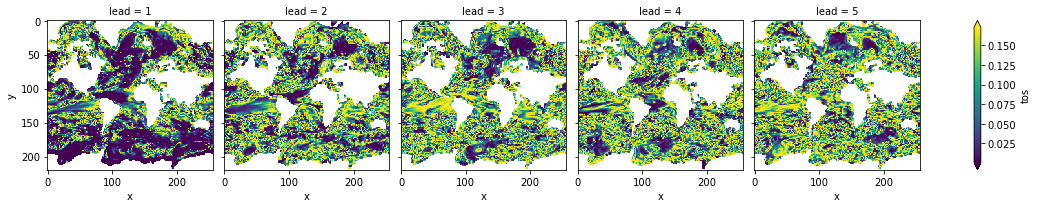

<IPython.core.display.Javascript object>

In [20]:
# difference due to FDR Benjamini-Hochberg
(acc_p_3d_fdr_corr - acc_p_3d).plot(col="lead", robust=True, yincrease=False, x="x")

FDR Benjamini-Hochberg increases the p-value and therefore reduces the number of significant grid cells.

### Bootstrapping with replacement

The same applies to bootstrapping with replacement.
First calculate the pvalue that uninitialized are better than initialized forecasts.
Then correct the FDR.

In [21]:
%%time
bootstrapped_acc_3d = pm.bootstrap(metric="pearson_r", comparison="m2e", dim=['init', 'member'],
                                   iterations=10, reference='uninitialized')['tos']

/Users/aaron.spring/Coding/climpred/climpred/checks.py:229: UserWarning: Consider chunking input `ds` along other dimensions than needed by algorithm, e.g. spatial dimensions, for parallelized performance increase.
  warnings.warn(


CPU times: user 10.5 s, sys: 3.2 s, total: 13.7 s
Wall time: 16.2 s


<IPython.core.display.Javascript object>

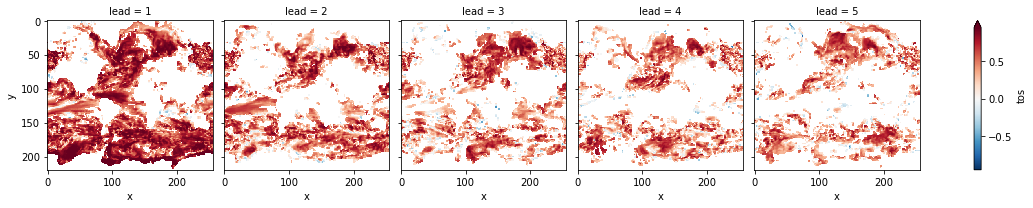

<IPython.core.display.Javascript object>

In [22]:
# mask init skill where not significant
bootstrapped_acc_3d.sel(skill="initialized", results="verify skill").where(
    bootstrapped_acc_3d.sel(skill="uninitialized", results="p") <= sig
).plot(col="lead", robust=True, yincrease=False, x="x")

In [23]:
# apply FDR Benjamini-Hochberg
_, bootstrapped_acc_p_3d_fdr_corr = multipletests(
    bootstrapped_acc_3d.sel(skill="uninitialized", results="p"),
    method="fdr_bh",
    alpha=sig,
)

<IPython.core.display.Javascript object>

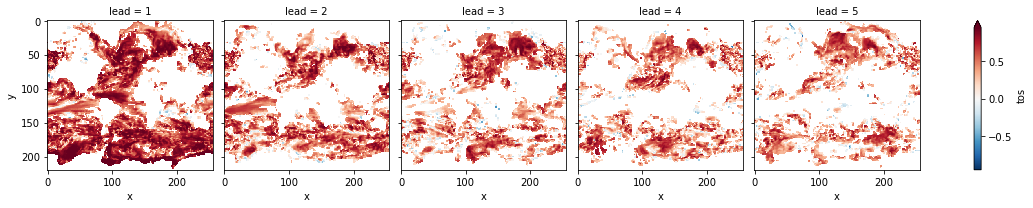

<IPython.core.display.Javascript object>

In [24]:
# mask init skill where not significant on corrected p-values
bootstrapped_acc_3d.sel(skill="initialized", results="verify skill").where(
    bootstrapped_acc_p_3d_fdr_corr <= sig * 2
).plot(col="lead", robust=True, yincrease=False, x="x")

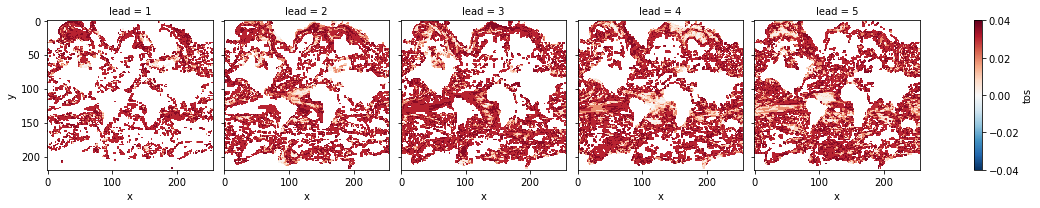

<IPython.core.display.Javascript object>

In [25]:
# difference due to FDR Benjamini-Hochberg
(
    bootstrapped_acc_p_3d_fdr_corr
    - bootstrapped_acc_3d.sel(skill="uninitialized", results="p").where(
        bootstrapped_acc_3d.sel(skill="uninitialized", results="p")
    )
).plot(
    col="lead",
    robust=True,
    yincrease=False,
    x="x",
    cmap="RdBu_r",
    vmin=-0.04,
    vmax=0.04,
)

FDR Benjamini-Hochberg increases the p-value and therefore reduces the number of significant grid cells.

## Coin test

Use xskillscore.sign_test to decide which forecast is better. Here we compare the initialized with the uninitialized forecast.

DelSole, T., & Tippett, M. K. (2016). Forecast Comparison Based on Random Walks. Monthly Weather Review, 144(2), 615–626. doi: 10/f782pf

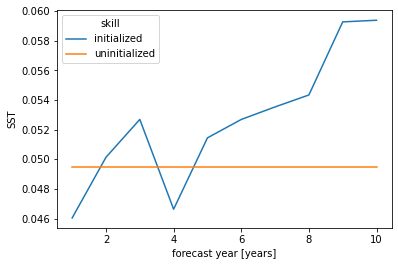

<IPython.core.display.Javascript object>

In [26]:
skill = hindcast.verify(
    metric="mae",
    comparison="e2o",
    dim=[],
    alignment="same_verif",
    reference="uninitialized",
)

# initialized skill is clearly better than historical skill
skill.mean("init").SST.plot(hue="skill")

In [27]:
from xskillscore import sign_test

<IPython.core.display.Javascript object>

In [28]:
# Next xskillscore version will allow datasets. Currently requires DataArrays.
skill = skill.SST

<IPython.core.display.Javascript object>

In [29]:
# orientation is negative since lower scores are better for MAE
walk = sign_test(
    skill.sel(skill="initialized"),
    skill.sel(skill="uninitialized"),
    time_dim="init",
    orientation="negative",
    alpha=sig,
)

<IPython.core.display.Javascript object>

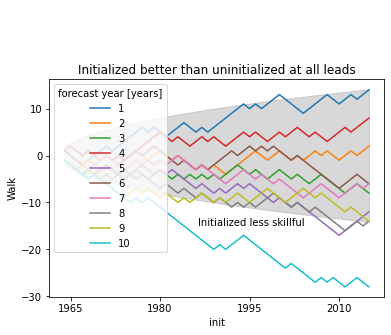

<IPython.core.display.Javascript object>

In [30]:
plt.rcParams["legend.loc"] = "upper left"
# positive walk means forecast1 (here initialized) is better than forecast2 (uninitialized)
# skillful when colored line above gray line following a random walk
# this gives you the possibility to see which inits have better skill (positive step) than reference
# the final inital init shows the combined result over all inits as the sign_test is a `cumsum`
conf = walk["confidence"].isel(lead=0)  # confidence is identical here for all leads
plt.fill_between(conf.init.values, conf, -conf, color="gray", alpha=0.3)
walk.plot(hue="lead")
plt.title("Initialized better than uninitialized at all leads")
plt.ylabel("Walk")
plt.annotate("Initialized more skillful", (-5000, 30), xycoords="data")
plt.annotate("Initialized less skillful", (-5000, -15), xycoords="data")
plt.show()